In [1]:
from transformers import SamModel, SamProcessor
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


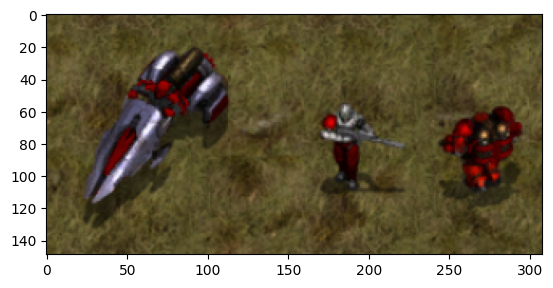

In [3]:
img = plt.imread('star.png')
img = img[:, :, :3]

plt.imshow(img)
plt.show()

In [5]:
points = [[[50,80]]]

In [6]:
if img.max() > 1.0:
    rescale = True
else:
    rescale = False

inputs = processor(images=img, input_points=points, return_tensors="pt",do_rescale=rescale).to(device)

outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

In [7]:
print(outputs.iou_scores)

tensor([[[0.7525, 0.7871, 0.9555]]], device='cuda:0', grad_fn=<SliceBackward0>)


In [8]:
print(masks[0][0][0])
print(masks[0][0][1])
print(masks[0][0][2])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  

In [9]:
def mask_to_rgb(*masks):
    mg = np.zeros(masks[0].shape + (4, ), dtype=np.uint8)

    for mask in masks:
        mg[mask == 1] = [0, 255, 0, 127]

    return mg

In [9]:
mr0 = mask_to_rgb(masks[0][0][0])
mr1 = mask_to_rgb(masks[0][0][1])
mr2 = mask_to_rgb(masks[0][0][2])

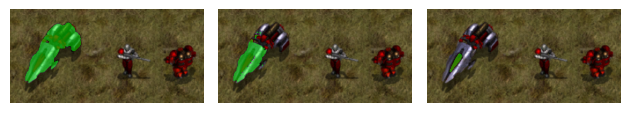

In [10]:
fig, axes = plt.subplots(1, 3)


axes[0].imshow(img)
axes[0].imshow(mr0)

axes[1].imshow(img)
axes[1].imshow(mr1)

axes[2].imshow(img)
axes[2].imshow(mr2)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 여러 객체를 여러 점으로 세그멘테이션

In [4]:
points = [[[[50,80],[50,110]],[[180,80],[177,107]], [[276,85],[279,115]]]]

In [6]:
if img.max() > 1.0:
    rescale = True
else:
    rescale = False

inputs = processor(images=img, input_points=points, return_tensors="pt",do_rescale=rescale).to(device)

outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

In [7]:
print(outputs.iou_scores)

tensor([[[0.9138, 0.8014, 0.8848],
         [0.8522, 0.9179, 0.8829],
         [0.8364, 0.9401, 0.6040]]], device='cuda:0', grad_fn=<SliceBackward0>)


In [10]:
mr0 = mask_to_rgb(masks[0][0][0],masks[0][1][0],masks[0][2][0])

mr1 = mask_to_rgb(masks[0][0][1],masks[0][1][1],masks[0][2][1])

mr2 = mask_to_rgb(masks[0][0][2],masks[0][1][2],masks[0][2][2])

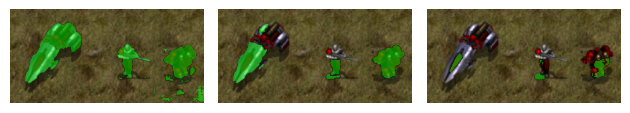

In [11]:
fig, axes = plt.subplots(1, 3)


axes[0].imshow(img)
axes[0].imshow(mr0)

axes[1].imshow(img)
axes[1].imshow(mr1)

axes[2].imshow(img)
axes[2].imshow(mr2)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 배경 제거

In [13]:
def transparent(img, *masks):

    if img.max() > 1.0:
        rescale = 255
    else:
        rescale = 1

    height, width, channels = img.shape
    alpha_channel = np.ones((height, width), dtype=np.uint8) * rescale
    image_with_alpha = np.dstack((img, alpha_channel))

    mask = sum(masks)
    image_with_alpha[mask == 0] = [0, 0, 0, 0]

    return image_with_alpha

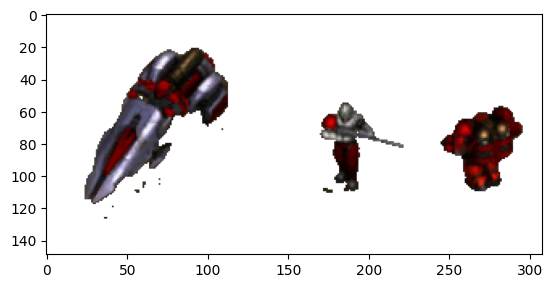

In [14]:
ri = transparent(img,masks[0][0][0],masks[0][1][0],masks[0][2][1])
plt.imsave('generated_image.png', ri)
plt.imshow(ri)
plt.show()